<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Построение-baseline-моделей" data-toc-modified-id="Построение-baseline-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Построение baseline моделей</a></span><ul class="toc-item"><li><span><a href="#Линейные-модели" data-toc-modified-id="Линейные-модели-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Линейные модели</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Бустинги" data-toc-modified-id="Бустинги-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Бустинги</a></span></li><li><span><a href="#Ансамбль-бустингов" data-toc-modified-id="Ансамбль-бустингов-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Ансамбль бустингов</a></span></li></ul></li></ul></li><li><span><a href="#Настройка-гиперпараметров" data-toc-modified-id="Настройка-гиперпараметров-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Настройка гиперпараметров</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель проекта** - построение модели, которая предсказывает количество заказов такси на следующий час. Метрика качества RMSE, которая должна быть меньше 48.

**Ход проекта**
1. Осмотр данных;
2. Анализ данных;
3. Обучение моделей;
4. Проверка лучшей модели на тестовой выборке.

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

Загрузим данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Выведем общую информацию о датафрейме.

In [3]:
def data_info(data):
    
    print('Первые 5 значений датасета')
    display(data.head())
    
    print('Информация о датасете')
    display(data.info())
    
    print(f'Размерность датасета: {data.shape}')
    print(f'Проверка датасета на монотонность: {data.index.is_monotonic}')
    print(f'Длина временного ряда: {data.index[-1] - data.index[0]}')
    print('\n')
    
    f, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(data["num_orders"], ax=ax, kde=True)
    ax.set_title('Распределение целевого признака')
    ax.set_xlabel('Количество заказов')
    ax.set_ylabel('Количество')

Первые 5 значений датасета


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Информация о датасете
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Размерность датасета: (26496, 1)
Проверка датасета на монотонность: True
Длина временного ряда: 183 days 23:50:00




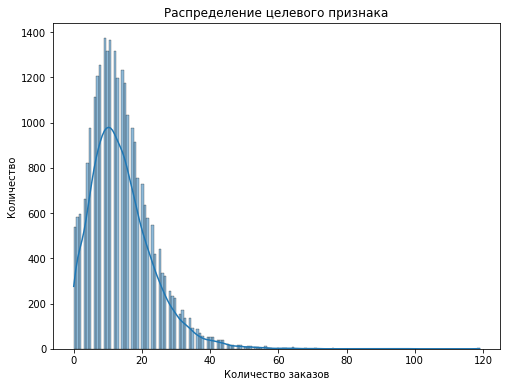

In [4]:
data_info(data)

**Выводы**

1. В данных отсутствуют пропущенные значения;
2. Ряд является монотонным;
3. Длина временного ряда составляет 184 дня;
4. Целевой признак имеет распределение Пуассона.


## Анализ

Проведем анализ временного ряда

In [5]:
def plot_data(data, period):
    
    '''
    Функция строит график по ресемплированным данным с заданным
    значением периода (period)
    Выводит суммарное значение и стандартное отклонение.
    '''
    
    f, ax = plt.subplots(1, 1, figsize=(12,6))
    
    data.resample(period).sum().plot(ax=ax)
    data.resample(period).std().plot(ax=ax)
    ax.legend(['sum_orders', 'std_orders'])
    ax.set_xlabel('Месяц')
    ax.set_ylabel('Заказы')

Ресемпл по часам.

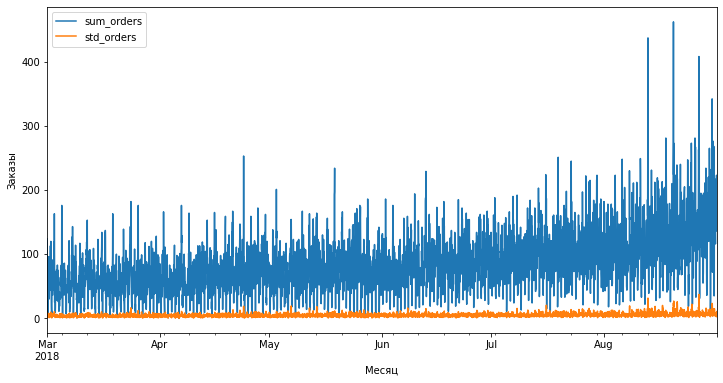

In [6]:
plot_data(data, '1H')

Ресемпл по дням.

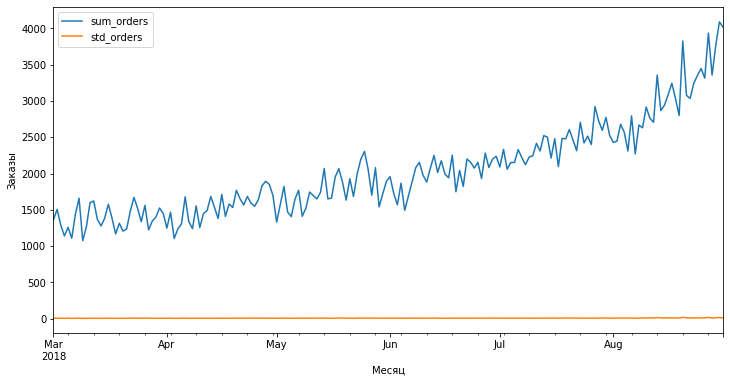

In [7]:
plot_data(data, '1D')

In [8]:
def plot_rolling(data, period, window=24):
    
    '''
    Функция строит график по ресемплированным данным с заданным
    значением периода (period) и строит скользящее среднее.
    '''
    
    f, ax = plt.subplots(1, 1, figsize=(12,6))
    
    data.resample(period).sum().plot(ax=ax)
    data.resample(period).sum().rolling(window).mean().plot(ax=ax)
    ax.set_xlabel('Месяц')
    ax.set_ylabel('Количество заказов')
    ax.legend(['mean_orders', 'rolling_mean_orders'])

Скользящее среднее по часам со скользящим 24 часа

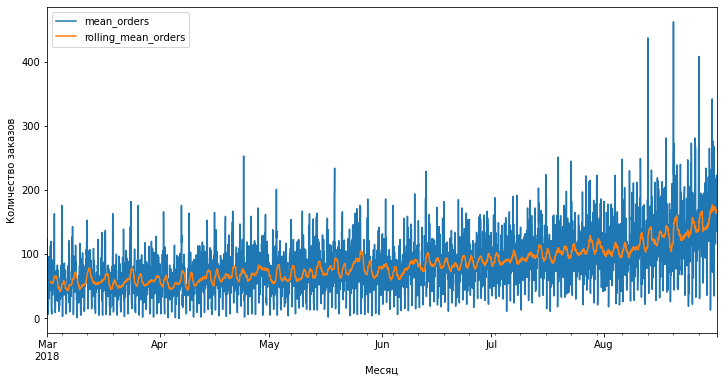

In [9]:
plot_rolling(data, '1H')

Скользящее среднее по дням со скользящим 7 дней.

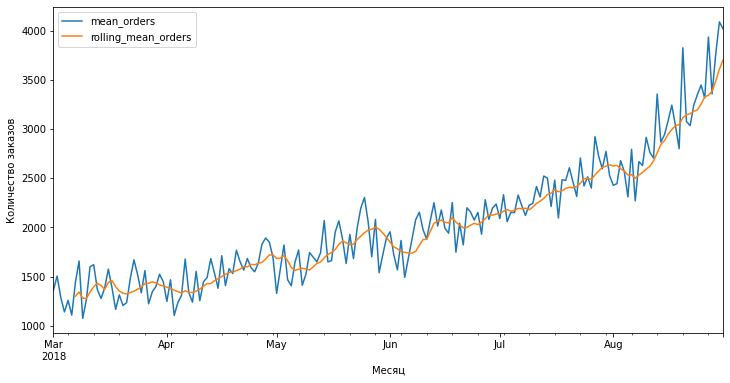

In [10]:
plot_rolling(data, '1D', 7)

**Вывод**

Судя по графикам, можно заключить, что компания находится в стадии роста. За полгода увеличивается суммарное количество заказов по часам, по дням. Так же это можно увидеть на графиках со скользящим средним.

Требуется проверка на стационарность ряда.

Разложим временной ряд на 3 составляющих: тренд, сезонность и остатки.

In [11]:
def plot_decomposed(data, period):
    
    '''
    Функция раскладывает семплированный (period) временной ряд на 3 составляющих:
    - тренд
    - сезон
    - остатки
    с дальнейшей визуализацией.
    '''
    
    temp_data = data.resample(period).sum()
    
    decomposed = seasonal_decompose(temp_data)
    
    plt.figure(figsize=(12, 9))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Тренд')
    plt.xlabel('Месяц')
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Сезонность')
    plt.xlabel('Месяц')
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Остатки')
    plt.xlabel('Месяц')
    
    plt.tight_layout()

Разберем на составляющие временной ряд по часам.

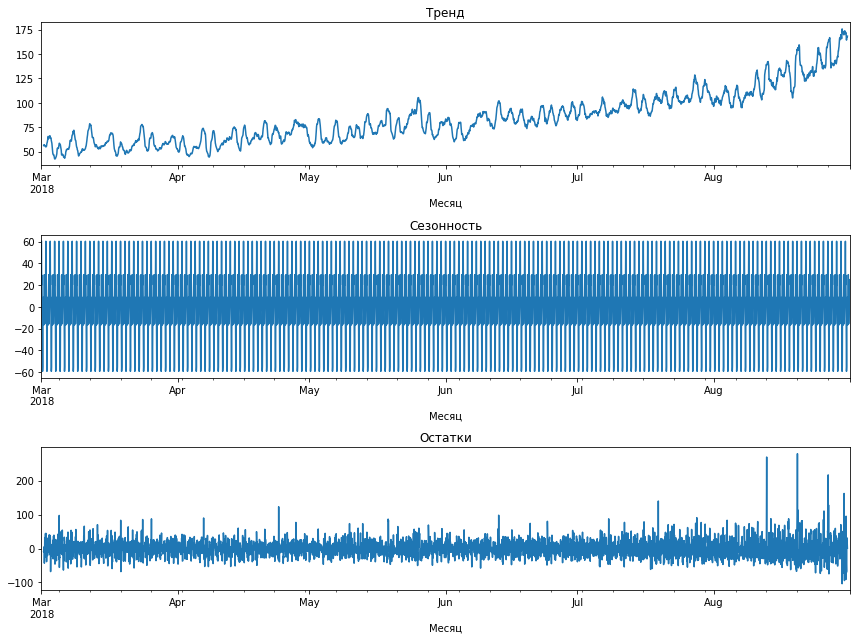

In [12]:
plot_decomposed(data, '1H')

Разберем на составляющие временной ряд по дням.

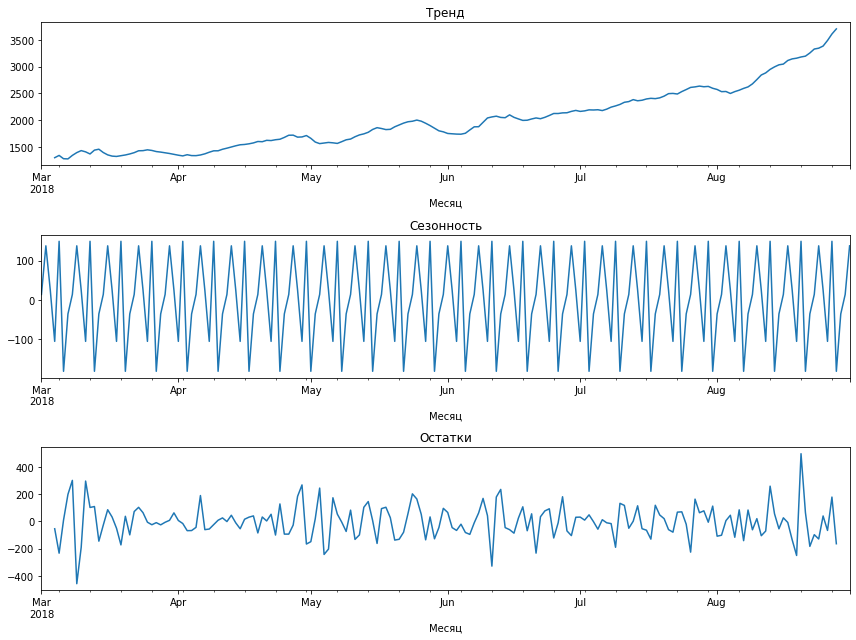

In [13]:
plot_decomposed(data, '1D')

**Вывод**

На двух семплированных временных ряда не удалось выделить сезонность (т.к. данные предоставлены только за полгода). Виден явный тренд на увеличение числа заказов. Остатки распределены нормально вокруг нуля, но иногда встречаются аномально большие значения.

Проверим на стационарность временной ряд с помощью критерия Дики-Фуллера.

In [14]:
def plot_ts(data, period='1H', lags=None, figsize=(12, 7), style='bmh'):
    
    '''
    Функция проверяет ряд на стационарность с помощью критерия Дики-Фуллера.
    Функция рисует сам ряд, автокорреляцию и частную автокорреляцию лагов.
    '''
    
    temp_data = data.resample(period).sum()

    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        temp_data['num_orders'].plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(temp_data['num_orders'], lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(temp_data['num_orders'], lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(temp_data['num_orders'])[1])

        plt.tight_layout()

Критерий Дики-Фуллера: p=0.028940


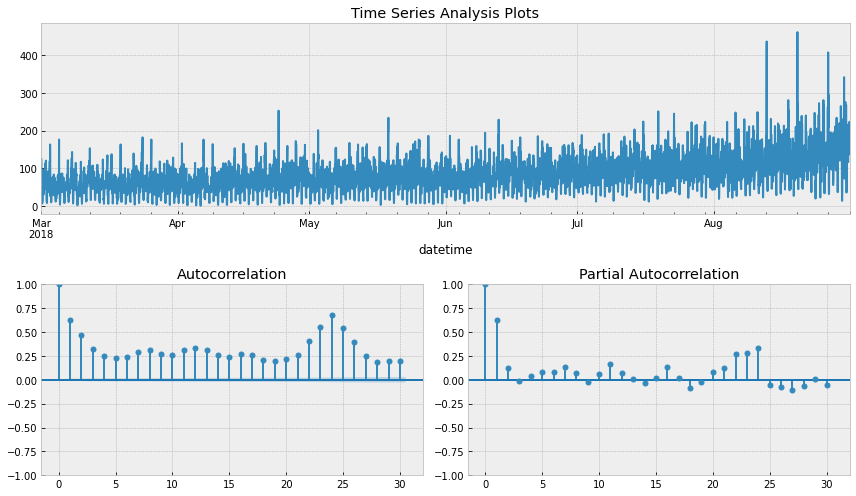

In [15]:
plot_ts(data, lags=30)

**Вывод**

В данном разделе был проанализирован временной ряд с семплирование по часу и по дням.

Выявлен тренд на увеличение суммы заказов. Ряд представлен 184 днями, из-за этого не удалось выявить сезонность. Остатки распределены нормально возле 0, иногда встречаются выбросы.

Судя по графикам среднее и стандартные отклонения увеличиваются со временем, но в данный ряд остается стационарным. (критерий Дики-Фуллера ~0.03 < 0.05 и результат является статистически значимым).

Обнаружена автокорреляция лагов, но она не явялется значительной.

## Обучение

Выполним ресемплирование по одному часу.

In [16]:
features = data.resample('1H').sum()

Напишем функцию для кодирования признаков средним значением

In [17]:
def mean_cat_feature(data, test_index, cat_feature, target_feature):

    return data[cat_feature].map(data[:test_index].groupby(cat_feature)[target_feature].mean())

Подготовим данные, разделим их на обучающую и тестовую выборки.

In [18]:
def prepare_data(data, start_lag=1, end_lag=30, rolling_window=6, test_size=0.1, holdout_size=0.1):
    
    '''
    Функция разделяется выборку на 3 части:
    X_train - тренировочная выборка;
    X_holdout - отложенная выборка;
    X_test - тестовая выборка,
    в соответветствии с необходимыми размерами test_size и holdout_size.
    
    Внутри функции создаются новые признаки:
    hour - час;
    weekday - день недели;
    is_weekend - является ли день выходным.
    
    Для часа и дня недели считается средняя сумма заказов (целевая переменная)
    только по тренировочному набору данных
    
    Создаются лаги с началом start_lag и концом end_lag
    
    Создается скользящее окно, которое считается по таргету,
    к нему добавлен метод .shift(), чтобы не происходило лика таргета.
    
    '''
    
    temp_data = data.copy()
    temp_data.columns = ['target']
    
    holdout_index = int(temp_data.shape[0] * (1 - test_size - holdout_size))
    test_index = int(temp_data.shape[0] * (1 - test_size))
    
    
    for ind in range(start_lag, end_lag):
        temp_data['lag_{}'.format(ind)] = temp_data['target'].shift(ind)
        
    temp_data['hour'] = temp_data.index.hour
    temp_data['weekday'] = temp_data.index.weekday
    temp_data['is_weekend'] = temp_data['weekday'].isin([5, 6]) * 1
    
    temp_data['weekday_average'] = mean_cat_feature(temp_data, test_index, 'weekday', 'target')
    temp_data['hour_average'] = mean_cat_feature(temp_data, test_index, 'hour', 'target')
    
    temp_data = temp_data.drop(['hour', 'weekday'], axis=1)
    
    temp_data['rolling_mean'] = temp_data['target'].shift().rolling(rolling_window).mean()
    
    
    temp_data = temp_data.dropna()
    temp_data = temp_data.reset_index(drop=True)
    
    X_train = temp_data.loc[:holdout_index].drop(['target'], axis=1)
    y_train = temp_data.loc[:holdout_index]['target']
    
    X_holdout = temp_data.loc[holdout_index:test_index].drop(['target'], axis=1)
    y_holdout = temp_data.loc[holdout_index:test_index]['target']
    
    X_test = temp_data.loc[test_index:].drop(['target'], axis=1)
    y_test = temp_data.loc[test_index:]['target']
    
    print('Размер тренировочной выборки:', X_train.shape)
    print('Размер отложенной выборки:', X_holdout.shape)
    print('Размер тестовой выборки:', X_test.shape)
    
    return X_train, X_holdout, X_test, y_train, y_holdout, y_test

In [19]:
X_train, X_holdout, X_test, y_train, y_holdout, y_test = prepare_data(features)

Размер тренировочной выборки: (3533, 33)
Размер отложенной выборки: (443, 33)
Размер тестовой выборки: (413, 33)


### Построение baseline моделей

Для прогнозирования целевого ряда будут использоваться:

1. Линейные модели (LinearRegression, Lasso)
2. Случайный лес (RandomForestRegressor)
3. Бустинги (Catboost, LGBM)

#### Линейные модели

In [20]:
def lr_predict(X_train, X_test, y_train, y_test):
    
    '''
    Функция обучает линейную регрессию.
    Предсказанные результаты выводятся вместе с действительными.
    '''
    
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, predict, squared=False)
    print(f'RMSE для Linear Regression: {rmse}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(predict, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Linear regression\n RMSE {}".format(round(rmse, 3)))
    plt.grid(True);

RMSE для Linear Regression: 32.90236265043218


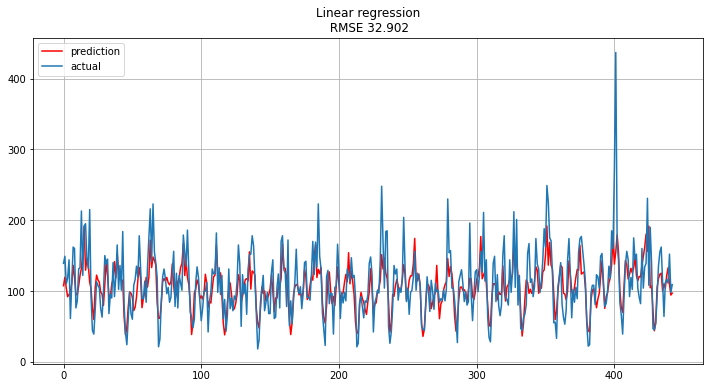

In [21]:
lr_predict(X_train, X_holdout, y_train, y_holdout)

In [22]:
def lasso_predict(X_train, X_test, y_train, y_test):
    
    '''
    Функция обучает линейную регрессию с L1 регуляризацией.
    Предсказанные результаты выводятся вместе с действительными.
    '''
    model = Lasso()
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, predict, squared=False)
    print(f'RMSE для Lasso: {rmse}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(predict, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Lasso\n RMSE {}".format(round(rmse, 3)))
    plt.grid(True);

RMSE для Lasso: 32.938693214696315


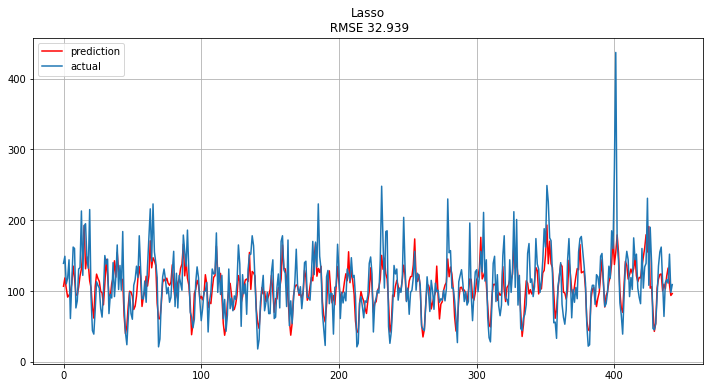

In [23]:
lasso_predict(X_train, X_holdout, y_train, y_holdout)

#### Случайный лес

In [24]:
def rf_predict(X_train, X_test, y_train, y_test):
    
    '''
    Функция обучает случайный лес.
    Предсказанные результаты выводятся вместе с действительными.
    '''
    
    model = RandomForestRegressor(random_state=17)
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, predict, squared=False)
    print(f'RMSE для RandomForestRegressor: {rmse}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(predict, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("RandomForestRegressor\n RMSE {}".format(round(rmse, 3)))
    plt.grid(True);

RMSE для RandomForestRegressor: 30.795567093267447


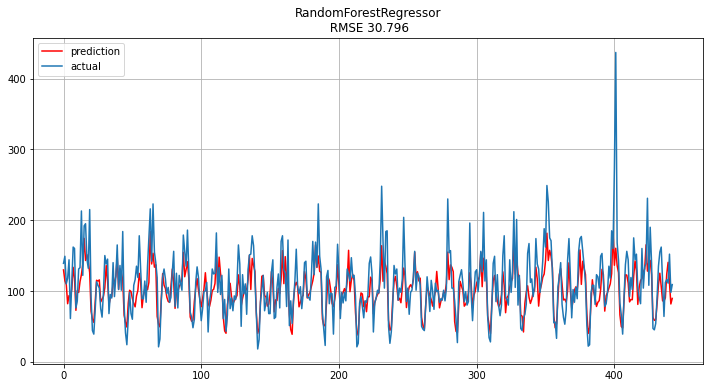

In [25]:
rf_predict(X_train, X_holdout, y_train, y_holdout)

#### Бустинги

In [26]:
def catboost_predict(X_train, X_test, y_train, y_test):
    
    '''
    Функция обучает CatBoostRegressor.
    Предсказанные результаты выводятся вместе с действительными.
    '''
    
    model = CatBoostRegressor(random_state=17,
                              verbose=False,
                              loss_function='RMSE')
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, predict, squared=False)
    print(f'RMSE для CatBoostRegressor: {rmse}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(predict, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("CatBoostRegressor\n RMSE {}".format(round(rmse, 3)))
    plt.grid(True);

RMSE для CatBoostRegressor: 30.31234463542965


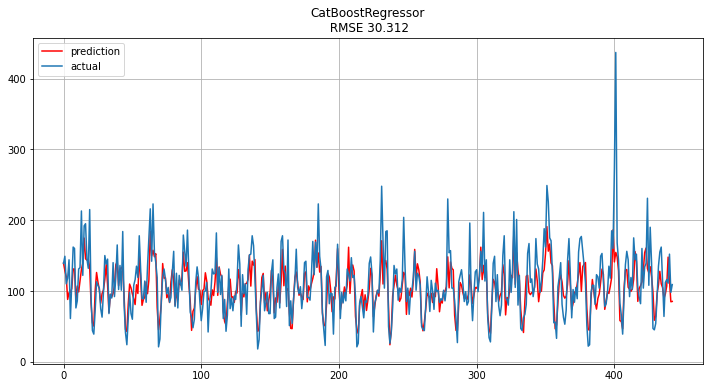

In [27]:
catboost_predict(X_train, X_holdout, y_train, y_holdout)

In [28]:
def lgbm_predict(X_train, X_test, y_train, y_test):
    
    '''
    Функция обучает LGBMRegressor.
    Предсказанные результаты выводятся вместе с действительными.
    '''
    
    model = LGBMRegressor(random_state=17,
                          objective='rmse')
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, predict, squared=False)
    print(f'RMSE для LightGBM: {rmse}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(predict, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("LightGBM\n RMSE {}".format(round(rmse, 3)))
    plt.grid(True);

RMSE для LightGBM: 30.397852846109096


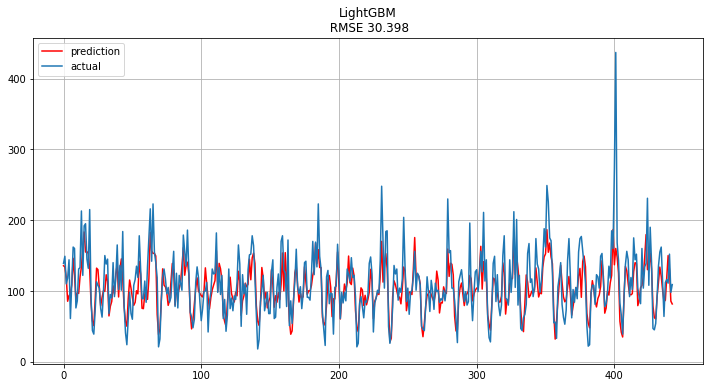

In [29]:
lgbm_predict(X_train, X_holdout, y_train, y_holdout)

#### Ансамбль бустингов

In [30]:
def ensemble_predict(X_train, X_test, y_train, y_test):
    
    '''
    Функция обучает ансамбль из CatBoostRegressor и LGBMRegressor.
    Итоговое значение складывается пополам.
    Предсказанные результаты выводятся вместе с действительными.
    '''
    
    lgb = LGBMRegressor(random_state=17)
    cb = CatBoostRegressor(random_state=17, verbose=False)
    
    lgb.fit(X_train, y_train)
    cb.fit(X_train, y_train)
    
    predict_lgb = lgb.predict(X_test)
    predict_cb = cb.predict(X_test)
    
    total_predict = 0.5 * predict_lgb + 0.5 * predict_cb
    
    rmse = mean_squared_error(y_test, total_predict, squared=False)
    print(f'RMSE для Ensemble: {rmse}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(total_predict, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Ensemble\n RMSE {}".format(round(rmse, 3)))
    plt.grid(True);

RMSE для Ensemble: 30.116213176918613


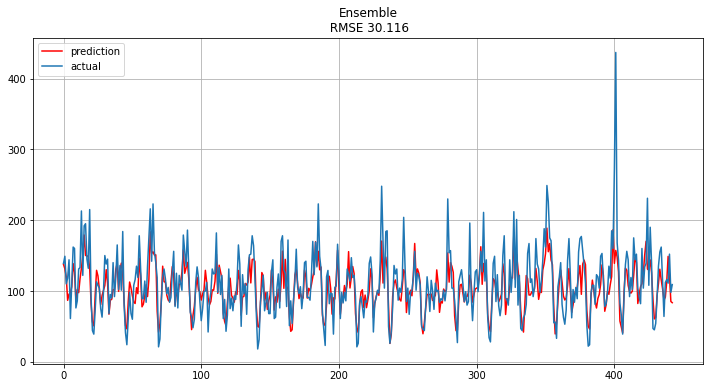

In [31]:
ensemble_predict(X_train, X_holdout, y_train, y_holdout)

**Выводы**

1. Линейные модели проявили себя хуже в данной задаче по сравнению с моделями на деревьях (RMSE линейных моделей ~33, у бустингов ~30.3). На графиках видно, что они не обладают достаточной обобщающей способностью, потому что в пиковых значениях часто показывают результат ниже необходимого.
2. Бустинги же проявили себя лучше всего. Модели CatBoost и LGBM практически идентичны по качеству;
3. Ансамбль из двух моделей показал лучшее качество на датасете. RMSE =30.116, что лучше на ~0.3, чем у каждого алгоритма по отдельности;
4. Бустинги строят зависимость более 'смело', но это приводит к тому, что зачастую они выходят за границы действительных значений;
5. Ни один алгоритм не смог хоть как-то зафиксировать выброс на 400 индексе.

## Настройка гиперпараметров

Настраивать гиперпараметры будем для модели CatBoostRegreesor и LGBMRegressor.

In [32]:
def find_best_catboost(iteration_list, X_train, X_test, y_train, y_test):
    
    '''
    Функция ищет лучшее значение iterations на отложенной выборке для CatBoostRegressor.
    Целевое значение rmse взято из baseline модели.
    '''
    
    rmse = 30.312
    best_iteration = None
    
    for iteration in iteration_list:
        
        model = CatBoostRegressor(random_state=17,
                                  verbose=False,
                                  iterations=iteration,
                                  loss_function='RMSE')
        
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        
        best_rmse = mean_squared_error(y_test, predict, squared=False)
        
        if rmse > best_rmse:
            rmse = best_rmse
            best_iteration = iteration
            
    print('Best RMSE is {}'.format(round(rmse, 3)))
    print('Best number of iterations is {}'.format(best_iteration))

In [33]:
iteration_list = [500, 700, 1000, 1500, 2000, 2500, 3000]

find_best_catboost(iteration_list, X_train, X_holdout, y_train, y_holdout)

Best RMSE is 30.052
Best number of iterations is 2500


In [34]:
def find_best_lgbm(learning_rate_list, n_est_list, max_depth_list, X_train, X_test, y_train, y_test):
    
    '''
    Функция ищет лучшее значение learning_rate, n_estimators, max_depth на отложенной выборке 
    для LGBMRegressor.
    Целевое значение rmse взято из baseline модели.
    '''
    
    rmse = 30.397
    best_estimators = None
    best_depth = None
    best_learning_rate = None
    
    for estimators in n_est_list:
        for depth in max_depth_list:
            for learn_rate in learning_rate_list:
                
                model = LGBMRegressor(random_state=17,
                                      objective='rmse',
                                      learning_rate=learn_rate,
                                      max_depth=depth,
                                      n_estimators=estimators)
        
                model.fit(X_train, y_train)
                predict = model.predict(X_test)
        
                best_rmse = mean_squared_error(y_test, predict, squared=False)
        
                if rmse > best_rmse:
                    rmse = best_rmse
                    best_estimators = estimators
                    best_depth = depth
                    best_learning_rate = learn_rate
            
    print('Best RMSE is {}'.format(round(rmse, 3)))
    print('Best number of estimators is {}'.format(best_estimators))
    print('Best learning rate is {}'.format(best_learning_rate))
    print('Best depth is {}'.format(best_depth))

In [35]:
learning_rate_list = [0.04, 0.06, 0.08]
n_est_list = [100, 200, 300, 400]
max_depth_list = [5, 6, 7]

find_best_lgbm(learning_rate_list, n_est_list, max_depth_list, X_train, X_holdout, y_train, y_holdout)

Best RMSE is 30.04
Best number of estimators is 400
Best learning rate is 0.04
Best depth is 7


**Вывод**

Для каждой модели после настройки гиперпараметров удалось снизить RMSE до 30.04 (предыдущие значения ~30.3).

## Тестирование

Для тестирование модели выберем ансамбль двух моделей с настроенными гиперпараметрами:
1. CatBoostRegressor
2. LGBMRegressor

Для обучения соединим тренировочную и отложенную выборки.

In [36]:
X_train_total = np.vstack((X_train, X_holdout))
y_train_total = np.hstack((y_train, y_holdout))

In [37]:
def test_ensemble(X_train, X_test, y_train, y_test):
    
    '''
    Функция делает предсказания на тестовой выборке.
    Ансамбль состоит из двух моделей:
    - LGBMRegressor;
    - CatBoostRegressor
    у которых настроены гиперпараметры.
    Предсказанные результаты выводятся вместе с действительными.
    '''
    
    lgb = LGBMRegressor(random_state=17,
                        n_estimators=400,
                        max_depth=7,
                        learning_rate=0.04,
                        objective='rmse')
    cb = CatBoostRegressor(random_state=17, 
                           verbose=False, 
                           iterations=2500,
                           loss_function='RMSE')
    
    lgb.fit(X_train, y_train)
    cb.fit(X_train, y_train)
    
    predict_lgb = lgb.predict(X_test)
    predict_cb = cb.predict(X_test)
    
    total_predict = 0.5 * predict_lgb + 0.5 * predict_cb
    
    rmse = mean_squared_error(y_test, total_predict, squared=False)
    print(f'RMSE для Ensemble на тестовой выборке: {rmse}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(total_predict, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Ensemble\n RMSE {}".format(round(rmse, 3)))
    plt.grid(True);

RMSE для Ensemble на тестовой выборке: 38.31844885448544


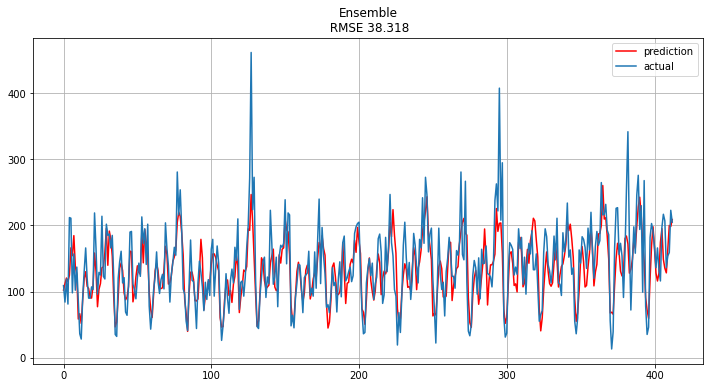

In [38]:
test_ensemble(X_train_total, X_test, y_train_total, y_test)

## Итоги

В данном проекте решалась задача предсказания количества заказов такси на следующий час. Метрикой качества предсказания выступила RMSE. Требуемое значение - 48.

Временной ряд составлял 184 дня. Целевой признак имеет распределение Пуассона.

В ходе анализа временного ряда не удалось установить сезонность (из-за маленького промежутка), но отчетливо виден тренд на возрастание количества заказов. Это видно по графикам суммарного количества и стандартного отклонения по часам и по дням. Остатки распределены нормально вокруг 0 с редкими выбросами.

Временной ряд был проверен на стационарность. Критерий Дики-Фуллера оказался равен 0.028, что меньше 0.05. Это значит, что ряд является стационарным.

На отложенной выборке были протестированы модели:
1. Линейные (LinearRegression RMSE = 32.902, Lasso RMSE = 32.939)
2. Случайный лес (RandomForestRegressor RMSE = 30.796)
3. Бустинги (CatBoostRegressor RMSE = 30.312, LightGBM RMSE = 30.398)

В итоге был выбран ансамбль из бустингов (Ensemble RMSE = 30.116). Данный ансамбль показал лучшее качество на отложенной выборке, и был больше ~0.2, чем у каждого из алгоритмов по отдельности.

В последствии у моделей были настроены гиперпараметры и итоговый ансамбль делал прогноз на тестовой выборке.

RMSE на тестовой выборке составил 38.318. Это значит, что модели переобучились.

Изучая график предсказаний на тестовой выборке можно выделить, что моделям намного лучше удается обработать выбросы (индексы 80, 120, 290), но они стали хуже прогнозировать типичные дни, часто завышая действительное значение. Возможно, что это связано с тем, что хоть ряд у нас и стационарный, но тренд на увеличение числа заказов существует и модели слишком сильно переоценили этот тренд. Так же предложением по улучшения является регуляризация, которая бы дала результат хуже на отложенной выборке, но результат на тесте был бы меньше (возможно).

Целевое значение метрики RMSE достингнуто.